# SW11-Exercises
## PID controller for a thermostat

Data has been arbitrarily invented. We use kWmins as unit.

In [8]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
from scipy.interpolate import interp1d

number_of_hours = 24 * 10 #Define the number of hours to simulate

irrad_data = np.loadtxt("irrad.txt")

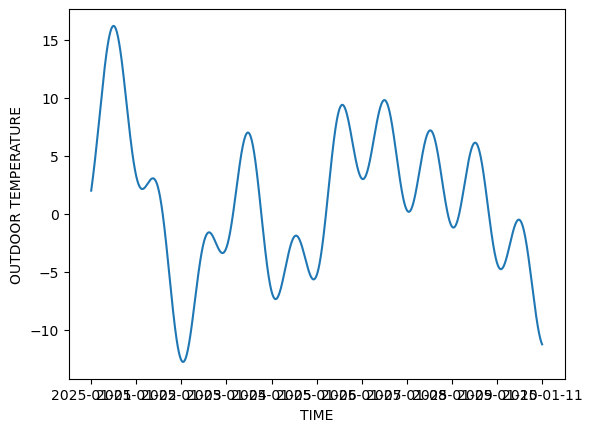

In [9]:
#Create temperature timeseries.

daily_means = np.array([
    6.0,  
    5.5,   
    -9.0, 
    3.5,  
    -6.0,  
    5.0,  
    5.5,
    3,
    1,
    -7,
    2,    
])

days = np.arange(len(daily_means))

# -------------------------------------------------------------
# STEP 2 — Smooth daily means to hourly resolution
# -------------------------------------------------------------
hours_total = len(daily_means) * 24
hour_axis = np.linspace(0, len(daily_means) - 1, hours_total)

# Smooth interpolation of daily means → eliminates jumps
smooth_daily_mean = interp1d(days, daily_means, kind="cubic")(hour_axis)

# -------------------------------------------------------------
# STEP 3 — Add smooth diurnal variation
# -------------------------------------------------------------
daily_amp = 4.0  # smooth sinusoidal amplitude
hour_of_day = np.arange(hours_total) % 24

# Smooth sine curve for daily cycle
diurnal_cycle = daily_amp * np.sin(2 * np.pi * (hour_of_day - 6) / 24)

# Combine mean + diurnal variation
hourly_temps = smooth_daily_mean + diurnal_cycle

# -------------------------------------------------------------
# STEP 4 — Interpolate to minute resolution
# -------------------------------------------------------------
minutes_total = hours_total * 60
minute_axis = np.linspace(0, hours_total - 1, minutes_total)

smooth_interp = interp1d(np.arange(hours_total), hourly_temps, kind="cubic")
minute_temps = smooth_interp(minute_axis)

# -------------------------------------------------------------
# STEP 5 — Create pandas time series
# -------------------------------------------------------------
start = pd.Timestamp("2025-01-01 00:00:00")
ts_index = pd.date_range(start, periods=minutes_total, freq="min")
temperature_series = pd.Series(minute_temps[:number_of_hours*60], index=ts_index[:number_of_hours*60])


plt.plot(temperature_series)
plt.xlabel("TIME")
plt.ylabel("OUTDOOR TEMPERATURE")
plt.show()

We model a room (situated in Aeugst am Albis) which is heated by a radiator. Our PID controller controls the temperature of the radiator at a minutely resolution.
The room gains energy from the radiator (or is cooled by it).
It looses energy by conduction through a wall.
Furthermore, it gains energy by irradiation.

In [10]:
import copy

#Definition of the function that calculates the response of the room.
def integrator(KP, 
               KD,
               KI, 
               T0pid = 30.0, 
               T_outdoor_timeseries = temperature_series, 
               irrad_timeseries = irrad_data/1000,
               Mth = 20.0, 
               gamma = 1.0, 
               delta = 1.3,  
               T_should=22.0, 
               Tindoor_start = [22.0, 22.0, 22.0]
               ):
    
    Tindoor = copy.deepcopy(Tindoor_start)
    T_outdoor_timeseries = list(T_outdoor_timeseries)
    Theating = [35.0, 35.0, 35.0]

    integrationterm_tot = 0.0

    for i in range(len(T_outdoor_timeseries)): #loop over all time steps to obtain response and indoor temperature at all time steps.

        i_tindoor = i+3

        natural_outflow = gamma * (Tindoor[-1] - T_outdoor_timeseries[i]) 
        heating_inflow = gamma * (Theating[-1] - Tindoor[-1])
        irrad_flow = irrad_timeseries[i]
        netflow = heating_inflow - natural_outflow + irrad_flow

        Tindoor.append(Tindoor[-1] + netflow/Mth)



        diff_term = (T_should - Tindoor[-1]) - (T_should - Tindoor[-2])
        proportional_term = (T_should - Tindoor[-1])

        Tnew = T0pid + KP*proportional_term + KD*diff_term + KI*integrationterm_tot

        Theating.append(Tnew)

        integrationterm_tot += (T_should - Tindoor[-1])

    return Theating[3:], T_outdoor_timeseries, Tindoor[3:]






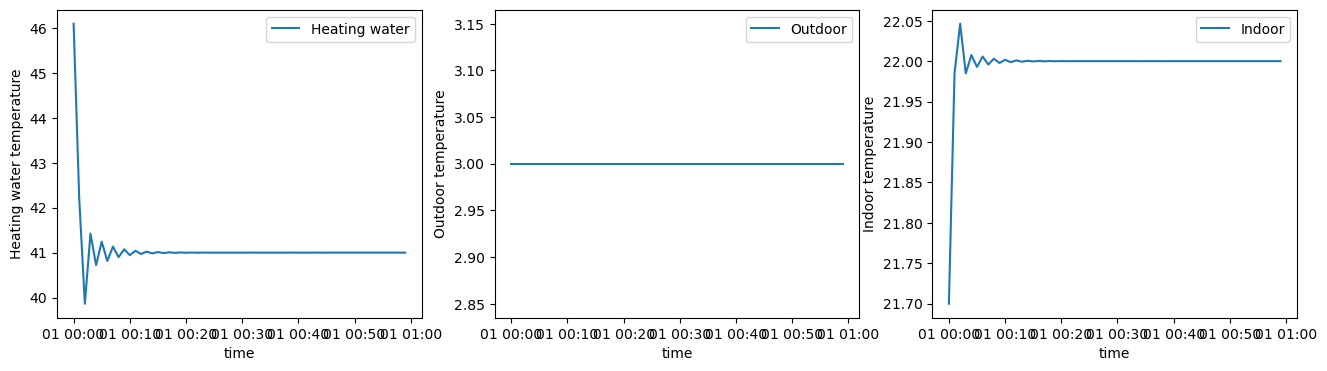

In [37]:
#Here you can try the response of the controller in a simple example: Outdoor tempeature = 3 degrees C, no irrandiance


ts1, ts2, ts3 = integrator(52.36,  1.286,  39.22, T_outdoor_timeseries = (temperature_series*0+3.0)[:60], irrad_timeseries = (irrad_data*0.0)[:60]) # KP, KD, KI

start = pd.Timestamp("2025-01-01 00:00:00")
ts_index = pd.date_range(start, periods=minutes_total, freq="min")

fig, axs = plt.subplots(1,3, figsize = (16,4))
axs[0].plot(pd.Series(ts1, index=ts_index[:len(ts1)]), label = "Heating water")
axs[0].set_xlabel("time")
axs[0].set_ylabel("Heating water temperature")
axs[0].legend()
axs[1].plot(pd.Series(ts2[:len(ts1)], index=ts_index[:len(ts1)]), label = "Outdoor")
axs[1].set_xlabel("time")
axs[1].set_ylabel("Outdoor temperature")
axs[1].legend()
axs[2].plot(pd.Series(ts3, index=ts_index[:len(ts3)]), label = "Indoor")
axs[2].set_xlabel("time")
axs[2].set_ylabel("Indoor temperature")
axs[2].legend()
plt.show()



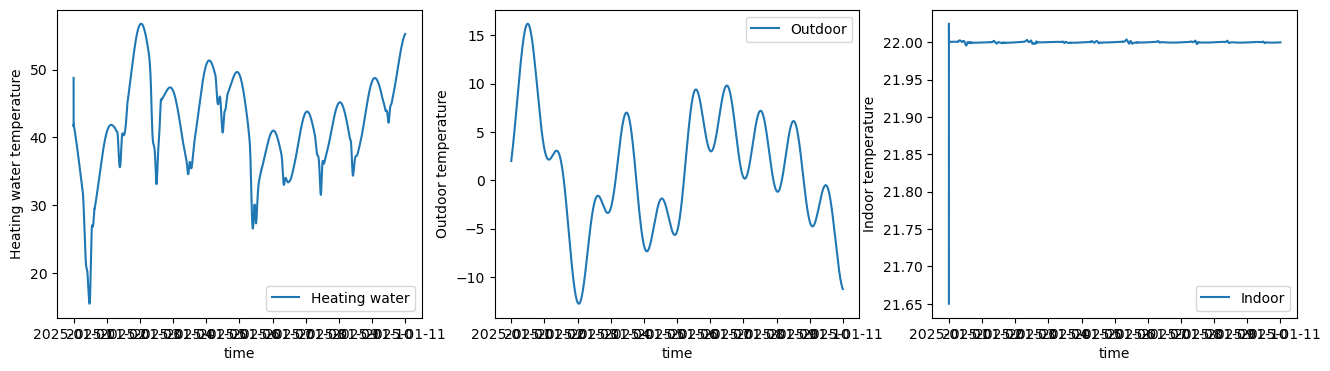

In [34]:
#Here is a more realistic example

ts1, ts2, ts3 = integrator(52.36,  1.286,  39.22, T_outdoor_timeseries = temperature_series, irrad_timeseries = irrad_data/1000) # KP, KD, KI

start = pd.Timestamp("2025-01-01 00:00:00")
ts_index = pd.date_range(start, periods=minutes_total, freq="min")

fig, axs = plt.subplots(1,3, figsize = (16,4))
axs[0].plot(pd.Series(ts1, index=ts_index[:len(ts1)]), label = "Heating water")
axs[0].set_xlabel("time")
axs[0].set_ylabel("Heating water temperature")
axs[0].legend()
axs[1].plot(pd.Series(ts2[:len(ts1)], index=ts_index[:len(ts1)]), label = "Outdoor")
axs[1].set_xlabel("time")
axs[1].set_ylabel("Outdoor temperature")
axs[1].legend()
axs[2].plot(pd.Series(ts3, index=ts_index[:len(ts3)]), label = "Indoor")
axs[2].set_xlabel("time")
axs[2].set_ylabel("Indoor temperature")
axs[2].legend()
plt.show()


In [35]:
#Optimization to find best parameters


from scipy.optimize import minimize
def errorsum_wrapped(x):
    KP, KD, KI = x
    ts1, ts2, ts3 = integrator(KP, KD, KI, T_outdoor_timeseries = temperature_series, irrad_timeseries = irrad_data/1000)
    return np.sum((np.array(ts3) - 22.0)**2)

# Perform the minimization
x0 = [20.0, 1.0, 10.0]
result = minimize(
    errorsum_wrapped,
    x0,
    method='L-BFGS-B',
    bounds=[(0, 100), (0, 100), (0, 100)],  # optional
    options={
        "maxiter": 5000,
        "ftol": 1e-12
    }
)
print(result)



  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 0.13232306227874463
        x: [ 5.236e+01  1.286e+00  3.922e+01]
      nit: 19
      jac: [ 7.050e-07  1.818e-06 -2.359e-07]
     nfev: 80
     njev: 20
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


37.32425878702992
684853.1603544767


/tmp/ipykernel_16439/2814764136.py:39: RuntimeWarning: overflow encountered in scalar multiply
  Tnew = T0pid + KP*proportional_term + KD*diff_term + KI*integrationterm_tot
/tmp/ipykernel_16439/2814764136.py:39: RuntimeWarning: invalid value encountered in scalar multiply
  Tnew = T0pid + KP*proportional_term + KD*diff_term + KI*integrationterm_tot
/tmp/ipykernel_16439/188362851.py:10: RuntimeWarning: overflow encountered in square
  return np.sum((np.array(ts3) - 22.0)**2)
/home/matfr/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/tmp/ipykernel_16439/2814764136.py:30: RuntimeWarning: overflow encountered in scalar subtract
  netflow = heating_inflow - natural_outflow + irrad_flow
/tmp/ipykernel_16439/2814764136.py:39: RuntimeWarning: overflow encountered in scalar add
  Tnew = T0pid + KP*proportional_term + KD*diff_term + KI*integrationterm_tot
/tmp/ipykerne

[[6.84853160e+05 7.11739790e+04 2.52878393e+04 1.28297161e+04
  7.73705668e+03 5.16911023e+03 3.69589657e+03 2.77324531e+03
  2.15744849e+03 1.72634376e+03            nan            nan
             nan            nan            nan            nan
             nan            nan            nan            nan]
 [           nan 9.31004081e+00 3.50032506e+00 2.38349806e+00
  1.90754303e+00 1.64243504e+00 1.47242795e+00 1.35346781e+00
  1.26565190e+00 1.20350656e+00            nan            nan
             nan            nan            nan            nan
             nan            nan            nan            nan]
 [           nan            nan 4.47658676e+00 1.56762027e+00
  1.00931899e+00 7.72346074e-01 6.41342830e-01 5.58387694e-01
  5.01624606e-01 4.62334181e-01 6.91390485e-01            nan
             nan            nan            nan            nan
             nan            nan            nan            nan]
 [           nan            nan            nan 2.94908827e+00
  1.0

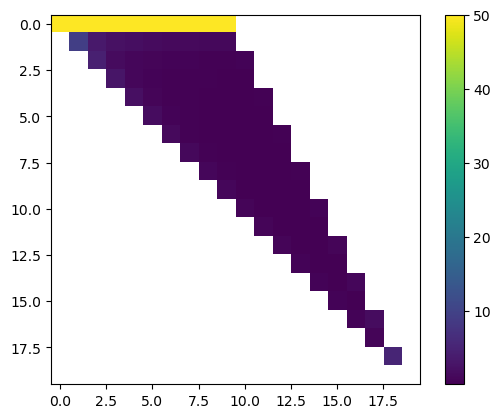

In [36]:

#Plot to find the optimal value in the plane (KP, KD=0, KI)



def errorsum_wrapped_from_KP_KI(KP, KI):
    KP = float(KP)
    KI = float(KI)
    KD = 0.0  # fixed
    ts1, ts2, ts3 = integrator(KP, KD, KI, T_outdoor_timeseries = temperature_series, irrad_timeseries = irrad_data/1000)
    return np.sum((np.array(ts3) - 22.0)**2)

print(errorsum_wrapped_from_KP_KI(2.0, 1.0))


KP_vals = np.linspace(0.0, 100.0, 100)   # adjust range as needed
KI_vals = np.linspace(-0.0, 100.0, 100)

KP_vals = np.linspace(0.0, 80.0, 20)   # adjust range as needed
KI_vals = np.linspace(0, 80.0, 20)


KP_grid, KI_grid = np.meshgrid(KP_vals, KI_vals)

# Empty array for results
Z = np.zeros_like(KP_grid)
print(errorsum_wrapped_from_KP_KI(0.0, 0.0))
# Evaluate function on the grid
for i in range(KP_grid.shape[0]):
    for j in range(KP_grid.shape[1]):
        val = errorsum_wrapped_from_KP_KI(KP_grid[i, j],
                                              KI_grid[i, j])
        Z[i, j] = val
print(Z)
plt.imshow(Z, vmax = 50)
plt.colorbar()
plt.show()


